In [1]:
from CONSTANT import *
from tools import *
import pandas as pd
import numpy as np
from torch.utils.data import (TensorDataset, DataLoader, SequentialSampler, WeightedRandomSampler)

from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoderLayer, TransformerDecoder
from torchmetrics import MeanSquaredError

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

from models import *

import torch

from torch import nn
import torch.nn.functional as F
import gc


use_cuda = False
valid='loso'

device = torch.device('cuda' if torch.cuda.is_available() and use_cuda else 'cpu')
print('using', device)

using cpu


In [2]:
from representation.SigRepre import MultiSignalRepresentation
from models.MER import *

In [3]:
class Params(object):
    def __init__(self, lr=0.001, epoch=100, valid='loso', target='valence', batch_size=64,):
        self.batch_size = batch_size
        self.valid = valid
        self.target = target
        self.epoch = epoch
        self.lr = lr
        self.metrics_dict = {}
        self.debug = True
        self.out_channels = 32
        self.out_channels = 32
        self.hidden_size = 64
        self.num_layers = 1
        self.fcn_input = 50432
        self.dropout=0.2
        self.use_cuda=False
        self.device=torch.device(
            'cuda' if torch.cuda.is_available() and self.use_cuda else 'cpu')

In [4]:
# spliter = load_model(r'./processed_signal/HKU956/400_12s_step_2s_spliter5.pkl')
# data = pd.read_pickle(r'./processed_signal/HKU956/400_4s_step_2s.pkl')
# data = pd.read_csv(r'./processed_signal/HKU956/400_4s_step_2s.csv')
spliter = load_model(r'./processed_signal/HKU956/772_12s_step_6s_spliter5.pkl')
data = pd.read_pickle(r'./processed_signal/HKU956/772_12s_step_6s.pkl')

for k in spliter[valid]:
    train_index = k['train_index']
    test_index = k['test_index']
    break

In [5]:
args = Params()
dataprepare = DataPrepare(args=args, target='valence', data=data, train_index=train_index, test_index=test_index, device=args.device)
# train_dataloader, test_dataloader = dataprepare.get_data()
xtest = dataprepare.xtest
xtrain = dataprepare.xtrain

xtest.shape, xtrain.shape

Target distribution:
1    4826
0    2112
dtype: int64
(1000, 4, 768) (1000, 1) (100, 4, 768) (100, 1)
Train target distribution
1    723
0    277
dtype: int64
Test target distribution
1    66
0    34
dtype: int64


(torch.Size([100, 4, 768]), torch.Size([1000, 4, 768]))

In [6]:
xtest.shape

torch.Size([100, 4, 768])

In [7]:
del data, dataprepare
gc.collect()

0

In [27]:
signals = pd.read_pickle(r'./processed_signal/all_768_12s_step_2s_sampled.pkl')
signals.shape

(816, 3074)

In [30]:
def concat_signals(df):
    bvp_cols = [
        fea for fea in df.columns.values if fea.split('_')[0] in ['BVP']
    ]
    eda_cols = [
        fea for fea in df.columns.values if fea.split('_')[0] in ['EDA']
    ]
    temp_cols = [
        fea for fea in df.columns.values if fea.split('_')[0] in ['TEMP']
    ]
    hr_cols = [fea for fea in df.columns.values if fea.split('_')[0] in ['HR']]

    signals = []
    for bvp, eda, temp, hr in zip(df[bvp_cols].values, df[eda_cols].values,
                                  df[temp_cols].values, df[hr_cols].values):
        signals.append([bvp, eda, temp, hr])

    return np.array(signals)

In [31]:
sig = concat_signals(signals)
sig.shape

(816, 4, 768)

In [32]:
xtest = torch.from_numpy(sig).to(args.device).float()

In [33]:
model_ = MultiSignalRepresentation(seq=768,
    output_size=40, pretrained=False, device=args.device)
model_.to(args.device)

model_.load_state_dict(torch.load(r'./representation/output/rep_0.0001_128_maskp0.8_checkpoint.pt'))
for name, parameter in model_.named_parameters():
    parameter.requires_grad = False

In [34]:
mse_ = MeanSquaredError().to(args.device)

In [113]:
import matplotlib.pyplot as plt

def plot_signal(sig1, sig2, title):
    plt.figure(figsize=(7, 5))
    plt.plot(range(len(sig1)), sig1, color='blue', alpha=0.3, label="Original")
    plt.plot(range(len(sig2)), sig2, '-', color='red', alpha=0.3, label="Predicted")
    plt.legend(loc="upper left")
    plt.title(title)
    plt.show()

In [61]:
xtest[0].reshape(1, -1, 768).shape

torch.Size([1, 4, 768])

In [88]:
from tqdm import tqdm
signal_names = ['BVP', 'EDA', 'TEMP', 'HR']
all_mse = []

for i in tqdm(range(xtest.shape[0])):
    avg_mse = []
    for pred_signal, signal_name in enumerate(signal_names):
        channel_mask = [1, 1, 1, 1]
        channel_mask[pred_signal] = 0
        channel_mask = np.array([[i]*768 for i in channel_mask]).reshape(1, -1, 768)
        masked_signal = (xtest[i].reshape(1, -1, 768).cpu().detach().numpy() * channel_mask)
        torch_masked_signal = torch.from_numpy(masked_signal).to(args.device).float()
        output = model_(torch_masked_signal)
        mse_res = mse_(output, torch_masked_signal).item()
        avg_mse.append(mse_res)
    all_mse.append(np.mean(avg_mse))
        # print('MSE', mse_res)

100%|██████████| 816/816 [07:34<00:00,  1.79it/s]


In [89]:
np.argmin(all_mse)

537

# Channel Mask

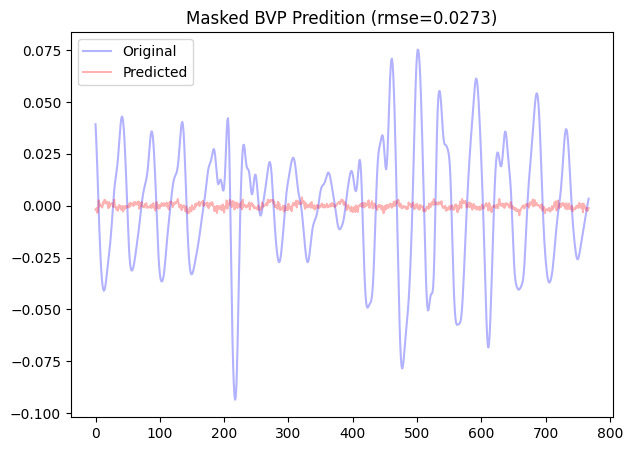

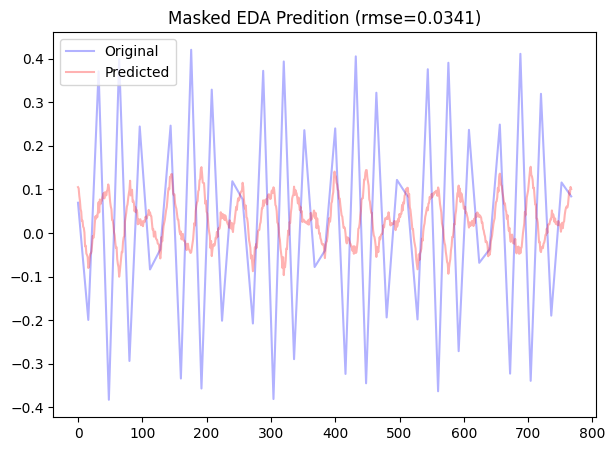

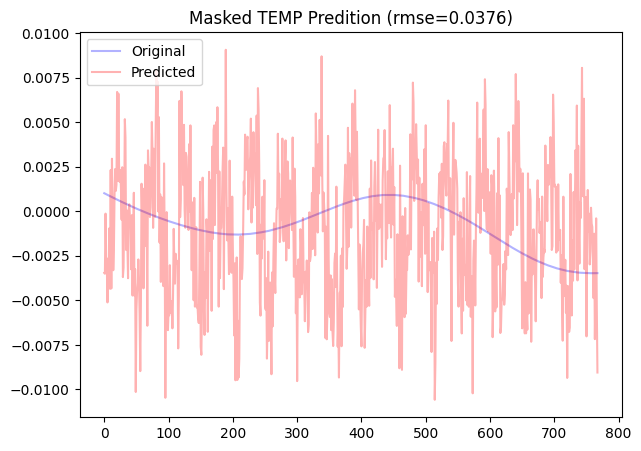

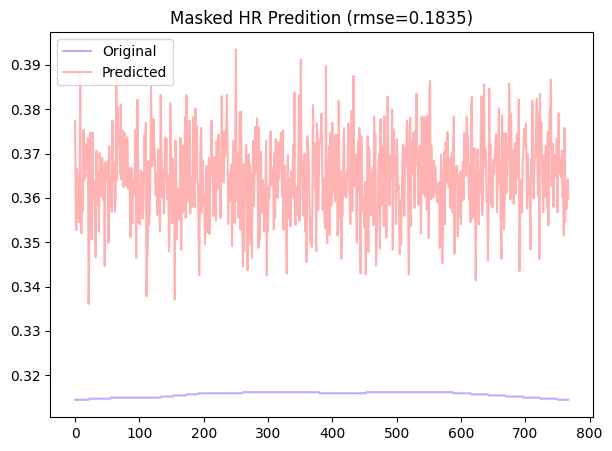

0.07059995519619709


In [114]:
signal_names = ['BVP', 'EDA', 'TEMP', 'HR']
signal_index = 537
avg_res = []
for pred_signal, signal_name in enumerate(signal_names):
    channel_mask = [1, 1, 1, 1]
    channel_mask[pred_signal] = 0
    channel_mask = np.array([[i]*768 for i in channel_mask]).reshape(1, -1, 768)
    masked_signal = (xtest[signal_index].reshape(1, -1, 768).cpu().detach().numpy() * channel_mask)
    torch_masked_signal = torch.from_numpy(masked_signal).to(args.device).float()
    output = model_(torch_masked_signal)
    mse_res = mse_(output, torch_masked_signal).item()
    # print('MSE', mse_res)
    avg_res.append(np.sqrt(mse_res))
    sig2 = output.cpu().detach().numpy()[0][pred_signal].tolist()
    sig1 = xtest.cpu().detach().numpy()[signal_index][pred_signal].tolist()
    plot_signal(sig1, sig2, 'Masked {0} Predition (rmse={1:.4f})'.format(signal_name, np.sqrt(mse_res)))
print(np.mean(avg_res))

# signal mask

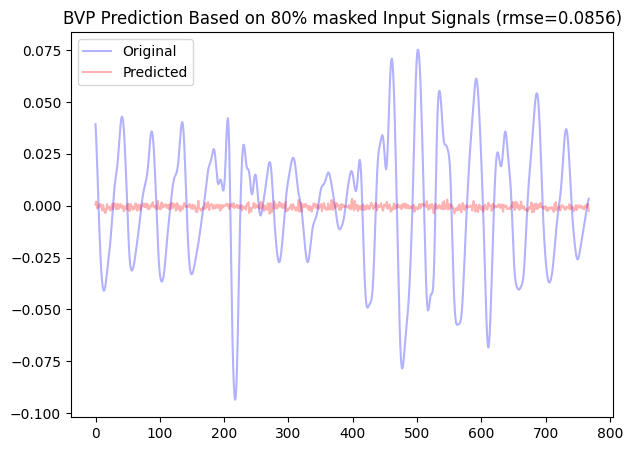

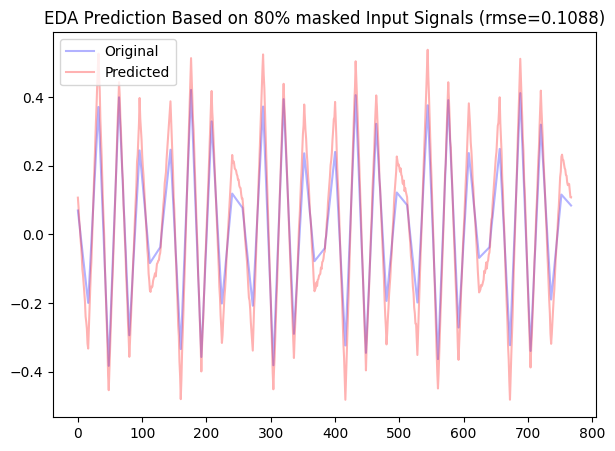

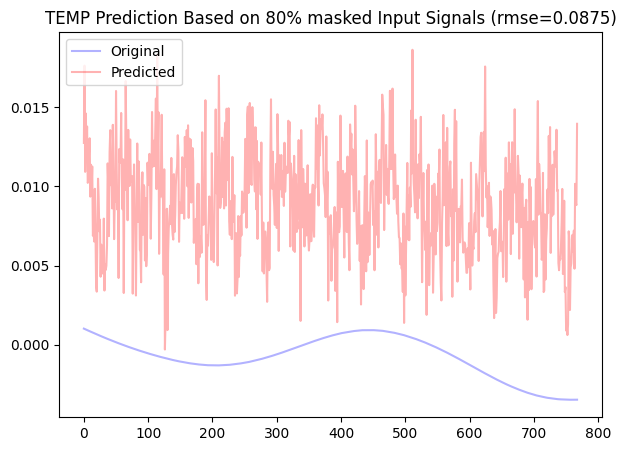

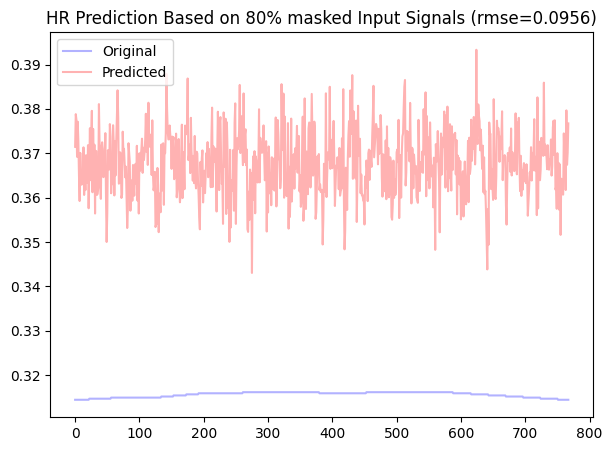

0.09436331858036187


In [115]:
signal_names = ['BVP', 'EDA', 'TEMP', 'HR']
signal_index = 537
avg_res = []
for pred_signal, signal_name in enumerate(signal_names):
    # channel_mask = [1, 1, 1, 1]
    # channel_mask[pred_signal] = 0
    # channel_mask = np.array([[i]*768 for i in channel_mask]).reshape(1, -1, 768)
    signal_mask = (torch.rand((1, 4, 768), device=args.device)
                       <= 0.8).int()
    masked_signal = (xtest[signal_index].reshape(1, -1, 768) * signal_mask)
    torch_masked_signal = masked_signal.to(args.device).float()
    output = model_(torch_masked_signal)
    mse_res = mse_(output, torch_masked_signal).item()
    # print('MSE', mse_res)
    avg_res.append(np.sqrt(mse_res))
    sig2 = output.cpu().detach().numpy()[0][pred_signal].tolist()
    sig1 = xtest.cpu().detach().numpy()[signal_index][pred_signal].tolist()
    plot_signal(sig1, sig2, '{0} Prediction Based on 80% masked Input Signals (rmse={1:.4f})'.format(signal_name, np.sqrt(mse_res)))
print(np.mean(avg_res))

# Full input

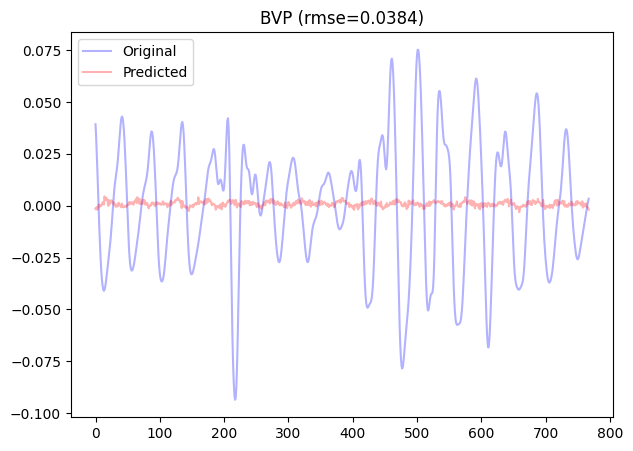

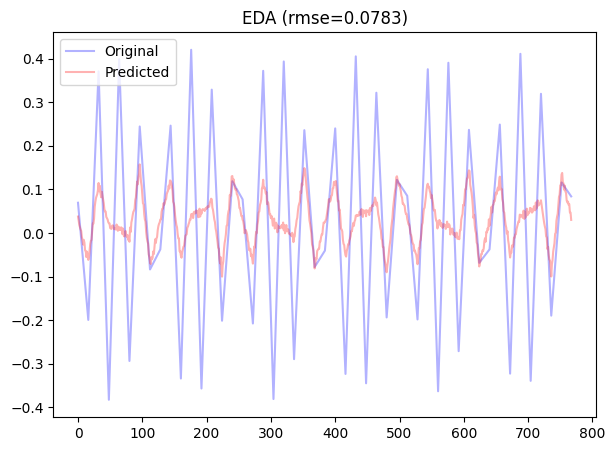

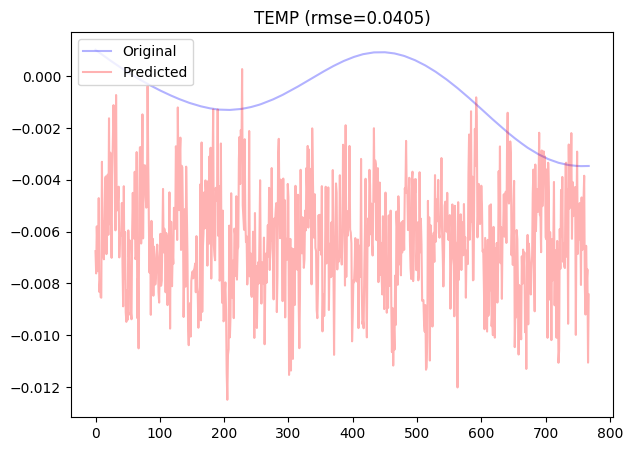

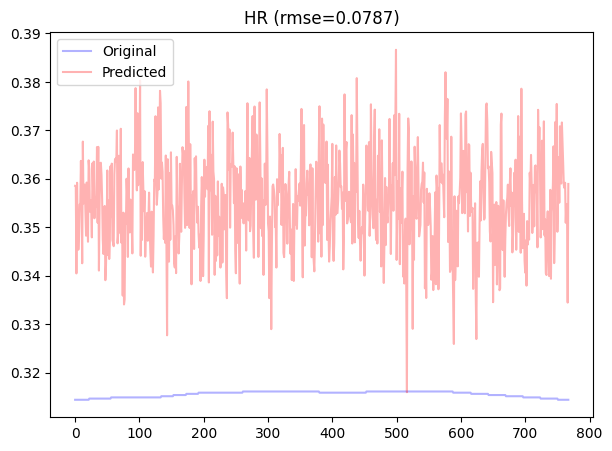

0.058990312659878114


In [116]:
signal_names = ['BVP', 'EDA', 'TEMP', 'HR']
signal_index = 537
avg_res = []
for pred_signal, signal_name in enumerate(signal_names):
    # channel_mask = [1, 1, 1, 1]
    # channel_mask[pred_signal] = 0
    # channel_mask = np.array([[i]*768 for i in channel_mask]).reshape(1, -1, 768)
    # masked_signal = (xtest[signal_index].reshape(1, -1, 768).cpu().detach().numpy() * channel_mask)
    torch_masked_signal = xtest[signal_index].reshape(1, -1, 768).to(args.device).float()
    output = model_(torch_masked_signal)
    mse_res = mse_(output, torch_masked_signal).item()
    # print('MSE', mse_res)
    avg_res.append(np.sqrt(mse_res))
    sig2 = output.cpu().detach().numpy()[0][pred_signal].tolist()
    sig1 = xtest.cpu().detach().numpy()[signal_index][pred_signal].tolist()
    plot_signal(sig1, sig2, '{0} (rmse={1:.4f})'.format(signal_name, np.sqrt(mse_res)))
print(np.mean(avg_res))